In [10]:
# Load the data
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

import torch
import torch.nn as nn
import torch.optim as optim

import skimage


############### Load climate model raw data for SST
with open('ssp585_time_series.pkl', 'rb') as f:
    data = pickle.load(f)


###################### Load ERA5 data

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# # define grid (+ croping for latitude > 60)
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

lat_size = lat.shape[0]
lon_size = lon.shape[0]

In [11]:
def data_processing(data):
    """ Process the data: statically relevant climate models (nb_runs > 3),
                            upscaling (from 0.25 to 0.5), 
                            cropping (remove latitude > 60),
                            time period focus (from 1981 until 2014)

        Args: 
            data: Dictionary of raw data (indexed by models and subdictionary indexed by runs)
        
        Returns:
            data_processed: upscaled data
            notnan_idx, nan_idx: non nan indices and nan indices i
    """
    # first filter out the models that contain less than 3 ensemble members 
    data_processed = {}

    # record nan indices as the union of nans on each map
    nan_idx = []
    
    for idx_m,m in enumerate(data.keys()):
        
        if len(data[m].keys()) > 3:

            data_processed[m] = data[m].copy()
            
            for idx_r, r in enumerate(data[m].keys()):

                # Upscaling of raw data 
                data_processed[m][r] = skimage.transform.downscale_local_mean(data_processed[m][r][131:164,:,:],(1,2,2))

                # capture nan indices and record the union of nans
                nan_idx_tmp = list(np.where(np.isnan(data_processed[m][r][0,:,:].ravel())==True)[0])
                nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

    # define not nan indices (useful to ease the computations)
    notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

    return data_processed, notnan_idx, nan_idx

In [12]:
def compute_anomalies(data,lontitude, latitude, nan_idx, time_period=33):
    """ Compute anomalies with respect to a given reference period.

        Args:
            - data: dictionary, preprocessed data
            - lontitude, latitude: numpy.array, longitude and latitude values
            - nan_idx: list of integers, list of nan indices in the flatten array
            - time_period: Int, time series lentgh (target period 1981-2014)
            
        Return:
            - data_anomalies: dictionary of centered (according to a specific definition) data
    """
    data_anomalies = {}

    lon_size = lontitude.shape[0]
    lat_size = latitude.shape[0]
    
    for idx_m,m in enumerate(data.keys()):
        data_anomalies[m] = data[m].copy()

        y_tmp = np.zeros((len(data[m].keys()),time_period, lat_size*lon_size))
    
        for idx_r, r in enumerate(data[m].keys()):

            # flatten the data
            y_tmp[idx_r,:,:] = data[m][r].copy().reshape(time_period, lat_size*lon_size)

            # replace continent's grid cell values with NaNs
            y_tmp[idx_r,:,nan_idx] = float('nan')
            

        # compute mean reference
        mean_ref_ensemble = np.nanmean(y_tmp,axis=1)
        mean_ref_ensemble = np.nanmean(mean_ref_ensemble,axis=0)

        # center the data with respect to the given mean
        for idx_r, r in enumerate(data[m].keys()):
            
            # compute anomalies
            data_anomalies[m][r] = y_tmp[idx_r,:,:] - mean_ref_ensemble

    return data_anomalies

In [13]:
def compute_forced_response(data,lontitude, latitude, nan_idx, time_period=33):
    """ Compute forced response.

        Args:
            - data: dictionary, preprocessed data
            - lontitude, latitude: numpy.array, longitude and latitude values
            - nan_idx: list of integers, list of nan indices in the flatten array
            - time_period: Int, time series lentgh (target period 1981-2014)
            
        Return:
            - data_anomalies: dictionary of centered (according to a specific definition) data
    """
    # compute the forced response
    data_forced_response = {}

    # get latitude size and longitude size
    lon_size = lontitude.shape[0]
    lat_size = latitude.shape[0]
    
    for idx_m,m in enumerate(data.keys()):
        
        data_forced_response[m] = data[m].copy()

        y_tmp = np.zeros((len(data[m].keys()),time_period, lat_size*lon_size))
    
        for idx_r, r in enumerate(data[m].keys()):

            # flatten the data
            y_tmp[idx_r,:,:] = data[m][r].copy().reshape(time_period, lat_size*lon_size)

            # replace continent's grid cell values with NaNs
            y_tmp[idx_r,:,nan_idx] = float('nan')
    
        
        # compute mean reference
        mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)

        # copmpute forced response (the same for each run)
        for idx_r, r in enumerate(data[m].keys()):              
            data_forced_response[m][r] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)

    return data_forced_response

In [14]:
def compute_variance(data,lontitude, latitude, nan_idx, time_period=33):
    """ Compute forced response.

        Args:
            - data: dictionary, preprocessed data
            - lontitude, latitude: numpy.array, longitude and latitude values
            - nan_idx: list of integers, list of nan indices in the flatten array
            - time_period: Int, time series lentgh (target period 1981-2014)
            
        Return:
            - data_anomalies: dictionary of centered (according to a specific definition) data
    """

    # compute the variance
    variance = {}

    # get latitude size and longitude size
    lon_size = lontitude.shape[0]
    lat_size = latitude.shape[0]
    
    for idx_m,m in enumerate(data.keys()):
        
        variance[m] = {}
        arr_tmp = np.zeros((len(data[m].keys()),time_period,lon_size*lat_size))
        
        for idx_r, r in enumerate(list(data[m].keys())):
            arr_tmp[idx_r,:,:] = data[m][r]
    
        variance[m] = np.var(arr_tmp,axis=0)

    return variance

In [15]:
def merge_runs(x,y,vars):
    """ Merge runs for each model.

        Args:
            x: dictionary, anomalies
            y: dictionary, forced response
            vars: dictionary, variance
            
        Return:
            x_merged, y_merged, vars_merged: dictionaries, concatenated runs for eadch model
    """
    y_merged = {}
    x_merged = {}
    vars_merged = {}
    
    for idx_m,m in enumerate(x.keys()):
        y_merged[m] = 0
        x_merged[m] = 0
        vars_merged[m] = 0
    
        for idx_r, r in enumerate(x[m].keys()):

            if idx_r ==0:
                y_merged[m] = y[m][r]
                x_merged[m] = x[m][r]
                vars_merged[m] = vars[m]
            else:
                y_merged[m] = torch.cat([y_merged[m],y[m][r]],dim=0 )
                x_merged[m] = torch.cat([x_merged[m], x[m][r]],dim=0)  
                vars_merged[m] = torch.cat([vars_merged[m], vars[m]],dim=0)
    
    return x_merged, y_merged, vars_merged    

In [16]:
def numpy_to_torch(x,y,vars):
    x_tmp = {}
    y_tmp = {}
    vars_tmp = {}

    for idx_m,m in enumerate(x.keys()):
        x_tmp[m] = {}
        y_tmp[m] = {}
        vars_tmp[m] = {}
        
        for idx_r, r in enumerate(x[m].keys()):
            x_tmp[m][r] = torch.from_numpy(x[m][r]).to(torch.float64)
            y_tmp[m][r] = torch.from_numpy(y[m][r]).to(torch.float64)
            
        vars_tmp[m] = torch.from_numpy(vars[m]).to(torch.float64)

    return x_tmp, y_tmp, vars_tmp

In [17]:
def standardize(x,y,vars,merged=False):
    """ Standardize dataset. 

        Args:
            x: dictionary, anomalies
            y: dictionary, forced response
            vars: dictionary, variance

        Return:
        
    """
    x_tmp = {}
    y_tmp = {}
    vars_tmp = {}
    
    for idx_m,m in enumerate(x.keys()):
        x_tmp[m] = {}
        y_tmp[m] = {}
        vars_tmp[m] = {}

        if merged == False:
            for idx_r, r in enumerate(x[m].keys()):
                x_tmp[m][r] = x[m][r]/torch.sqrt(vars[m])
                y_tmp[m][r] = y[m][r]/torch.sqrt(vars[m])
        else:
            x_tmp[m] = x[m]/torch.sqrt(vars[m])
            y_tmp[m] = y[m]/torch.sqrt(vars[m])

    
    return x_tmp, y_tmp

In [19]:
data_processed, notnan_idx, nan_idx = data_processing(data)
x = compute_anomalies(data_processed,lon, lat, nan_idx, time_period=33)
y = compute_forced_response(data_processed,lon, lat, nan_idx, time_period=33)
vars = compute_variance(x,lon, lat, nan_idx, time_period=33)

# convert numpy arrays to pytorch 
x, y, vars = numpy_to_torch(x,y,vars)

# standardize data 
x, y = standardize(x,y,vars)

# merge runs for each model
x_merged, y_merged, vars_merged = merge_runs(x,y,vars)

/tmp/ipykernel_40080/2317712706.py:33: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=1)
/tmp/ipykernel_40080/2317712706.py:34: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(mean_ref_ensemble,axis=0)
/tmp/ipykernel_40080/1106925613.py:36: RuntimeWarning: Mean of empty slice
  mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)
/tmp/ipykernel_40080/1106925613.py:40: RuntimeWarning: Mean of empty slice
  data_forced_response[m][r] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)


In [20]:
def build_training_and_test_sets(m_out,x,y,longitude,latitude,time_period=33):
    """Concatenate training sets for all models except model m. This enables to create the big matrices X and Y.

       Args:

       Return:
    """
    # merge runs for each model
    x_merged, y_merged, vars_merged = merge_runs(x,y,vars)

    # get the size of longitude and latitude arrays
    lon_size = longitude.shape[0]
    lat_size = latitude.shape[0]

        
    # We construct X, Y in R^{grid x runs*time steps}
    x_train = 0
    y_train = 0

    # We construct X_test, Y_test in R^{grid x runs*time steps}
    x_test = x_merged[m_out]
    y_test = y_merged[m_out]

    # Concatenate all models to build the matrix X
    count_tmp = 0
    for idx_m,m in enumerate(x.keys()):

        if m != m_out:
            if count_tmp ==0:
                x_train = x_merged[m]
                y_train = y_merged[m]
                count_tmp +=1
            else:
                x_train = torch.cat([x_train, x_merged[m]],dim=0)
                y_train = torch.cat([y_train, y_merged[m]],dim=0)

    return x_train, y_train, x_test, y_test

In [22]:
x.keys()

dict_keys(['CanESM5-1', 'CNRM-ESM2-1', 'GISS-E2-2-G', 'CNRM-CM6-1', 'MIROC-ES2L', 'HadGEM3-GC31-MM', 'EC-Earth3', 'GISS-E2-1-H', 'EC-Earth3-Veg', 'HadGEM3-GC31-LL', 'MIROC6', 'CESM2', 'FGOALS-g3', 'GISS-E2-1-G', 'MRI-ESM2-0', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'CanESM5', 'ACCESS-CM2', 'MPI-ESM1-2-LR', 'UKESM1-0-LL'])

In [23]:
m0 = 'CanESM5-1'

x_train, y_train, x_test, y_test = build_training_and_test_sets(m0,x,y,lon,lat,time_period=33)

# 1- Ridge regression problem: 
# $\min_{W} \Vert Y - X W \Vert_F^2 + \lambda \Vert W \Vert_F^2$

In [24]:
def Ridge_regression_closed_form(X, Y, lambda_=1.0):
    """
    Computes the closed-form solution for reduced rank regression.
    
    Args:
        X (torch.Tensor): Predictor matrix of shape (n, p).
        Y (torch.Tensor): Response matrix of shape (n, q).
        lambda_ (scalar): Ridge penalty coefficient.
        
    Returns:
        U (torch.Tensor): Low-rank predictor coefficients of shape (p, rank).
        V (torch.Tensor): Low-rank response coefficients of shape (q, rank).
    """

    # compute Penroe Morose pseudo inverse of X^T @ X
    P = torch.linalg.inv(X.T @ X + lambda_ * torch.eye(X.shape[1]))
    
    # compute ordinary least square solution 
    W_ols = P @ X.T @ Y

    # print loss function
    loss = torch.norm(Y - X @ W_ols,p='fro')**2 + lambda_ * torch.norm(W_ols,p='fro')**2
    print("Loss function: ", loss.item())
    
    return W_ols

# 2- Ridge regression problem: 
# $\min_{W \colon \mathrm{rank}(W) \leq r} \Vert Y - X W \Vert_F^2 + \lambda \Vert W \Vert_F^2$

In [25]:
def RRR_closed_form(X, Y, rank=5.0, lambda_=1.0):
    """
    Computes the closed-form solution for reduced rank regression.
    
    Args:
        X (torch.Tensor): Predictor matrix of shape (n, p).
        Y (torch.Tensor): Response matrix of shape (n, q).
        rank (Int): Desired rank for the approximation.
        lambda_ (Float64): Ridge penalty coefficient.
        
    Returns:
        U (torch.Tensor): Low-rank predictor coefficients of shape (p, rank).
        V (torch.Tensor): Low-rank response coefficients of shape (q, rank).
    """

    # compute Penroe Morose pseudo inverse of X^T @ X
    P = torch.linalg.inv(X.T @ X + lambda_ * torch.eye(X.shape[1]))
    
    # compute ordinary least square solution 
    W_ols = P @ X.T @ Y
    
    # compute SVD decomposition of X @ W_ols
    U, S, Vh = torch.linalg.svd(X @ W_ols, full_matrices=False)
    
    # Truncate to the desired rank
    U_r = U[:, :rank]            # (p, rank)
    S_r = torch.diag(S[:rank])   # (rank, rank)
    V_r = Vh[:rank, :].T         # (q, rank)

    # compute regressor
    W_rrr = W_ols @ V_r @ V_r.T

    # print loss function
    loss = torch.norm(Y - X @ W_rrr,p='fro')**2 + lambda_ * torch.norm(W_rrr,p='fro')**2
    print("Loss function: ", loss.item())

    return W_rrr

In [26]:
# compute ridge regressor
W_ridge = Ridge_regression_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], lambda_=1.0)

# compute low rank ridge regressor
r = 70
W_rrr = RRR_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=1.0)

# compute low rank ridge regressor
r = 10
W_rrr = RRR_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=1.0)

# compute low rank ridge regressor
r = 5
W_rrr = RRR_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=1.0)

Loss function:  1420750.998855838
Loss function:  2088646.5107346664
Loss function:  4552861.791370526
Loss function:  8247225.915686787


LOO rmse ridge regression  0.17942422067251584
LOO rmse RRR (rank= 5 )   0.1547432300153332


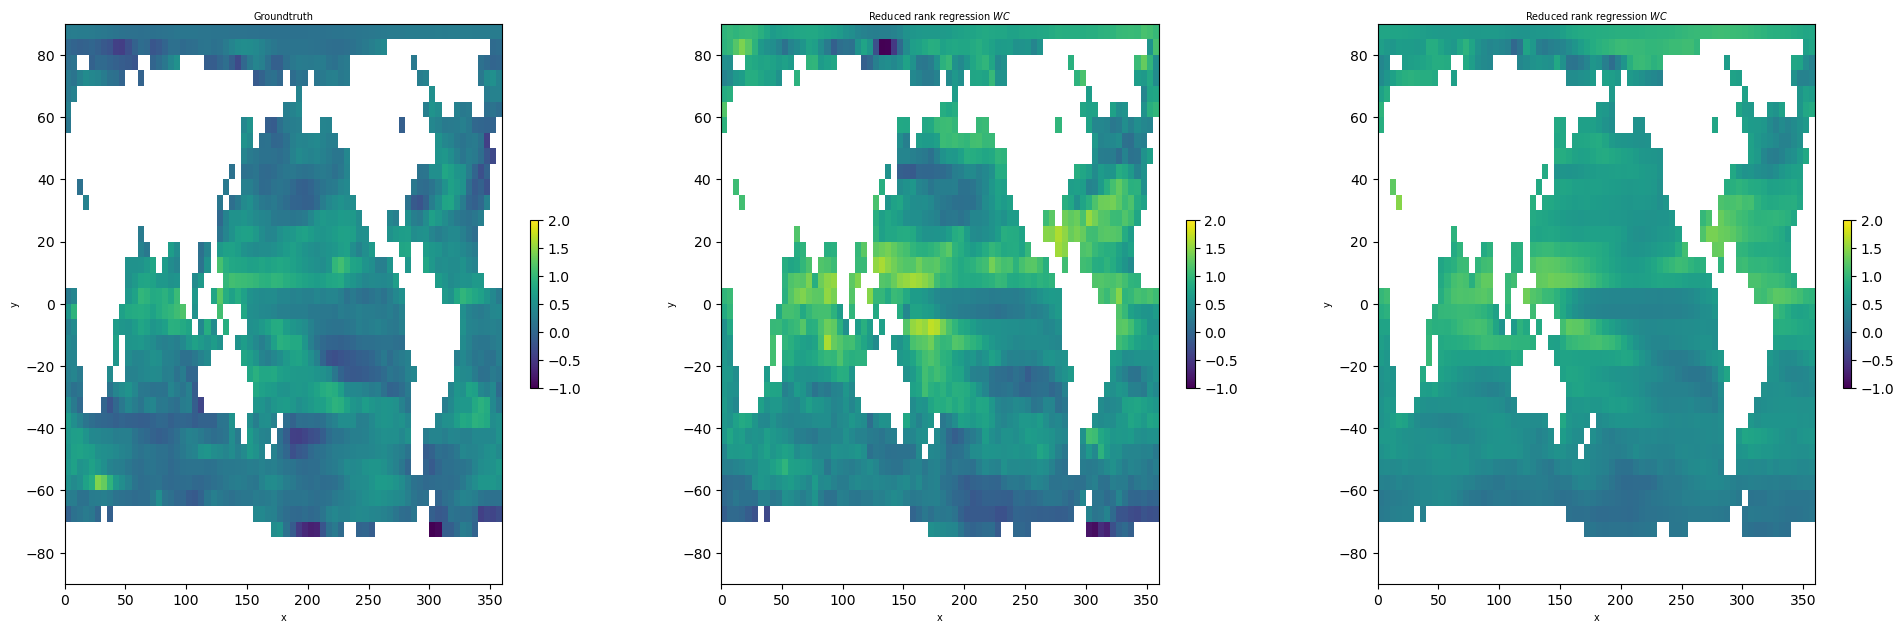

In [27]:
y_pred_ridge = torch.ones_like(x_test).to(torch.float64)
y_pred_ridge[:,nan_idx] = float('nan')
y_pred_ridge[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W_ridge.to(torch.float64)

y_pred_rrr = torch.ones_like(x_test).to(torch.float64)
y_pred_rrr[:,nan_idx] = float('nan')
y_pred_rrr[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W_rrr.to(torch.float64)

print("LOO rmse ridge regression ", torch.nanmean((y_pred_ridge - y_test)**2).item())
print("LOO rmse RRR (rank=",r,")  ", torch.nanmean((y_pred_rrr - y_test)**2).item())

y_target = y_test[:33,:]
y_target_pred_ridge = y_pred_ridge[:33,:]
y_target_pred_rrr = y_pred_rrr[:33,:]


# display Y map for a given model m0
time_idx = 20
y_target[:,nan_idx] = float('nan')
y_target_pred_ridge[:,nan_idx] = float('nan')
y_target_pred_rrr[:,nan_idx] = float('nan')

y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_ridge = y_target_pred_ridge[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_rrr = y_target_pred_rrr[time_idx,:].detach().numpy().reshape(lat_size,lon_size)


plt.close('all')
fig0 = plt.figure(figsize=(24,16))           

ax0 = fig0.add_subplot(2, 3, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 3, 2)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 3, 3)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_rrr,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

plt.show()

## Display predicted forced response for first run of left out climate model

In [29]:
from matplotlib import animation

time_period=33

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()


plt.close('all')
fig0 = plt.figure(figsize=(24,16))

ax0 = fig0.add_subplot(1, 3, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(1, 3, 2)        
ax1.set_title(r'Ridge regression', size=7,pad=3.0)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)

ax2 = fig0.add_subplot(1, 3, 3)        
ax2.set_title(r'Low rank regression', size=7,pad=3.0)
ax2.set_xlabel(r'x', size=7)
ax2.set_ylabel(r'y', size=7)

y_to_plot_target = y_target[0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_rrr = y_target_pred_rrr[0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_ridge = y_target_pred_ridge[0,:].detach().numpy().reshape(lat_size,lon_size)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=-1.0,vmax=2.0)
im2 = ax2.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_rrr,vmin=-1.0,vmax=2.0)


def animate_maps(i):

    y_to_plot_target = y_target[i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred_ridge = y_target_pred_ridge[i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred_rrr = y_target_pred_rrr[i,:].detach().numpy().reshape(lat_size,lon_size)

    im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
    im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=-1.0,vmax=2.0)
    im2 = ax2.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_rrr,vmin=-1.0,vmax=2.0)
    
plt.colorbar(im0, ax=ax0, shrink=0.3)
plt.colorbar(im1, ax=ax1, shrink=0.3)
plt.colorbar(im2, ax=ax2, shrink=0.3)
animation.FuncAnimation(fig0, animate_maps, frames=time_period)

# Robust weight ridge regression

# $\max_{\alpha \in \Delta} \min_{W} \sum_{m} \alpha_m \Vert \Sigma^{-1/2}(Y_m - X_m W) \Vert_F^2 + \lambda \Vert W \Vert_F^2$

### Compute gradient with respect to $W$

In [30]:
def compute_gradient(models,x,y,w,lambda_=1.0,mu_=1.0):
    """This function computes the gradient of ridge log-sum-exp loss with respect to W.

    Args:
        
    Returns:
        - Gradient matrix: torch.tensor d x d
    """
    res = torch.zeros(len(models), w.shape[0], w.shape[0]).to(torch.float64)
    res_sumexp = torch.zeros(len(models)).to(torch.float64)
    
    for idx_m, m in enumerate(models):
        for idx_r, r in enumerate(x[m].keys()):

            # compute -2X_{m,r}^T (Y_{m,r}^T - X_{m,r}^T W)
            res[idx_m][np.ix_(notnan_idx,notnan_idx)] -= 2*x[m][r][:,notnan_idx].T @ \
                                                        (y[m][r][:,notnan_idx] - x[m][r][:,notnan_idx] @ w[np.ix_(notnan_idx,notnan_idx)])

            # compute the exponential term
            res_sumexp[idx_m] += torch.norm(y[m][r][:,notnan_idx] - x[m][r][:,notnan_idx] @ w[np.ix_(notnan_idx,notnan_idx)], p='fro')**2

        res[idx_m] = res[idx_m] / len(x_predictor[m].keys())
        res_sumexp[idx_m] = res_sumexp[idx_m]/(len(x_predictor[m].keys())*mu_)
        
    
    softmax = torch.nn.Softmax(dim=0)
    res_sumexp = softmax(res_sumexp)

    grad = torch.zeros(w.shape[0], w.shape[0]).to(torch.float64)
    for idx_m, m in enumerate(models):
        grad[np.ix_(notnan_idx,notnan_idx)] += res_sumexp[idx_m]*res[idx_m][np.ix_(notnan_idx,notnan_idx)]
        
    grad = grad + 2*lambda_* w
    
    return grad 

### Gradient descent algorithm

In [ ]:
def low_rank_projection(w,rank=5):
    """Compute low rank projection.

        Args:

        Returns:
    """

    # compute SVD decomposition of W
    U, S, Vh = torch.linalg.svd(w.to(torch.float64), full_matrices=False)
    
    # Truncate to the desired rank
    U_r = U[:, :rank]            # (p, rank)
    S_r = torch.diag(S[:rank])   # (rank, rank)
    V_r = Vh[:rank, :].T         # (q, rank)

    # compute regressor
    w_low_rank = U_r @ S_r @ V_r.T 

    return w_low_rank

In [ ]:
def gradient_descent(models,x,y,lambda_=1.0,mu_=1.0,nb_iterations=10,alpha_ =0.1):
    """This function computes the gradient of ridge log-sum-exp loss with respect to W.

       Args:
            
       Returns:
    """
    w = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
    w_old = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
    # w = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)

    training_loss = torch.zeros(nb_iterations)
    
    # run a simple loop
    for it in range(nb_iterations):


        # accelerate gradient descent
        if it > 1:
            w_tmp = w + ((it-1)/(it+2)) * (w - w_old)
        else:
            w_tmp = w.detach()

        # save old parameter
        w_old = w.clone().detach()

        # compute gradient
        grad = compute_gradient(models,x,y,w_tmp,lambda_,mu_)

        
        # update the variable w
        w = w_tmp - alpha_ * grad

        # projection
        # w = low_rank_projection(w,rank=5)

        # compute loss functon to check convergence 
        res = torch.zeros(len(models))
        
        for idx_m, m in enumerate(models):  
            for idx_r, r in enumerate(x_predictor[m].keys()):
                res[idx_m] += torch.sum((y[m][idx_r*time_period:(idx_r+1)*time_period,notnan_idx] -x[m][idx_r*time_period:(idx_r+1)*time_period,notnan_idx] @ w[notnan_idx,:][:,notnan_idx] )**2)
                
            res[idx_m] = res[idx_m]/len(x_predictor[m].keys())
            
        obj = mu_*torch.logsumexp((1/mu_)* res,0)
        obj += lambda_*torch.norm(w,p='fro')**2

        print("Loss function: ", obj.item())
        
        training_loss[it] = obj.item()

    plt.close('all')
    plt.figure()
    plt.plot(range(nb_iterations),training_loss)
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.show()
    
    return w

In [ ]:
w_robust_ridge = gradient_descent(training_models,x_train,y_train,lambda_=100.0,mu_=0.5,nb_iterations=100,alpha_ =0.00001)

In [ ]:
y_pred = torch.ones_like(x_test).to(torch.float64)
y_pred[:,nan_idx] = float('nan')
y_pred[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ w_robust_ridge[notnan_idx,:][:,notnan_idx].to(torch.float64)

y_target = y_test[:33,:]
y_target_pred = y_pred[:33,:]


# display Y map for a given model m0
time_idx = 20
y_target[:,nan_idx] = float('nan')
y_target_pred[:,nan_idx] = float('nan')

y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred = y_target_pred[time_idx,:].detach().numpy().reshape(lat_size,lon_size)

print("RMSE : ", torch.nanmean((y_test - y_pred)**2))


plt.close('all')
fig0 = plt.figure(figsize=(24,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 2, 2)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

plt.show()

In [ ]:
from matplotlib import animation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()


plt.close('all')
fig0 = plt.figure(figsize=(24,16))

ax0 = fig0.add_subplot(1, 2, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(1, 2, 2)        
ax1.set_title(r'Robust reduced rank regression ', size=7,pad=3.0)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)

y_to_plot_target = y_target[0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred = y_target_pred[0,:].detach().numpy().reshape(lat_size,lon_size)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)


def animate_maps(i):

    y_to_plot_target = y_target[i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred = y_target_pred[i,:].detach().numpy().reshape(lat_size,lon_size)

    im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
    im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
    
plt.colorbar(im0, ax=ax0, shrink=0.3)
plt.colorbar(im1, ax=ax1, shrink=0.3)
plt.tight_layout()
animation.FuncAnimation(fig0, animate_maps, frames=time_period)

# Leave-one-out procedure

In [ ]:
def leave_one_out(model_out,x,y,vars,lon_size,lat_size,time_period=33,rank=5,lambda_=1.0,method='ridge',mu_=1.0,verbose=True):

    # Data preprocessing
    training_models = []
    x_train = {}
    y_train = {}

    x_test = {}
    y_test = {}
    

    # I need to go through all models to compute the training size
    count_dim = 0
    count_dim_m_out = 0
    for idx_m,m in enumerate(x.keys()):
        if m != model_out:
            training_models.append(m)
            count_dim += x[m].shape[0]
        else:
            count_dim_m_out += x[m].shape[0]
        


    #### Now we build the training set and test set

    # We want to build X and Y in R^{runs*time steps x grid size}

    # training set 
    x_train = torch.zeros(count_dim, lat_size*lon_size)
    y_train = torch.zeros(count_dim, lat_size*lon_size)

    # test set
    x_test = torch.zeros(count_dim_m_out, lat_size*lon_size)
    y_test = torch.zeros(count_dim_m_out, lat_size*lon_size)

    count_tmp =0 
    
    for idx_m,m in enumerate(x.keys()):
    
        if m != model_out:
            training_models.append(m)
            if count_tmp ==0:
                x_train[:x[m].shape[0],:] = x[m]/torch.sqrt(vars[m])
                y_train[:y[m].shape[0],:] = y[m]/torch.sqrt(vars[m])
                count_tmp = x[m].shape[0]
        
            else:
                x_train[count_tmp:count_tmp+x[m].shape[0],:] = x[m]/torch.sqrt(vars[m])
                y_train[count_tmp:count_tmp+y[m].shape[0],:] = y[m]/torch.sqrt(vars[m])
                count_tmp += x[m].shape[0]
    
        else: 
            x_test = torch.nan_to_num(torch.from_numpy(x[m]))/torch.sqrt(vars[m])
            y_test = torch.nan_to_num(torch.from_numpy(y[m]))/torch.sqrt(vars[m])

    
    # if method = ridge, then we train the ridge regression model
    if method == 'ridge':

        # compute ridge regression coefficient 
        W = Ridge_regression_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], lambda_)

    elif method == 'rrr':

        # compute low rank ridge regression coefficient
        W = RRR_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], rank, lambda_)

    elif method == 'robust':

        # compute low rank ridge regression coefficient
        W = gradient_descent(training_models,x_train,y_train,lambda_,mu_,nb_iterations=50,alpha_ =0.00001)

    # Predictions on test set
    y_pred = torch.ones_like(x_test).to(torch.float64)
    y_pred[:,nan_idx] = float('nan')
    y_pred[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W.to(torch.float64)

    # get training errors
    y_pred_train = {}
    rmse_train = {}

    for idx_m,m in enumerate(x.keys()):
        if m != model_out:
            y_pred_train[m] = torch.zeros_like(torch.from_numpy(x[m])).to(torch.float64)
            y_pred_train[m][:,notnan_idx] =  (x[m]/torch.sqrt(vars[m]))[:,notnan_idx] @ W.to(torch.float64)
            rmse_train[m] = torch.nanmean((y_pred_train[m] - y[m])**2)
           
    # if method == 'robust rrr':
    #     weights = compute_weights(x_train,y_train,vars,beta,lon_size,lat_size,selected_models,mu_)
    # else:
    #     weights = {m: (1/len(x.keys())) for m in x.keys()}
    

    return W, y_pred, y_test, rmse_train

In [ ]:
# W_ridge, y_pred, y_test, rmse_train = leave_one_out(m0,x_predictor_concatenate,y_forced_response_concatenate,var_train,\
#                                   lon_size,lat_size,time_period=33,\
#                                   rank=5,lambda_=100.0,method='ridge',mu_=1.0,verbose=True)

W_robust, y_pred, y_test, rmse_train = leave_one_out(m0,x_predictor_concatenate,y_forced_response_concatenate,var_train,\
                                                  lon_size,lat_size,time_period=33,\
                                                  rank=5,lambda_=100.0,method='robust',mu_=1.0,verbose=True)

In [ ]:
y_pred_ridge = torch.ones_like(x_test).to(torch.float64)
y_pred_ridge[:,nan_idx] = float('nan')
y_pred_ridge[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W_ridge.to(torch.float64)

y_pred_rrr = torch.ones_like(x_test).to(torch.float64)
y_pred_rrr[:,nan_idx] = float('nan')
y_pred_rrr[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W_rrr.to(torch.float64)

print("LOO rmse ridge regression ", torch.nanmean((y_pred_ridge - y_test)**2).item())
print("LOO rmse RRR (rank=",r,")  ", torch.nanmean((y_pred_rrr - y_test)**2).item())

y_target = y_test[:33,:]
y_target_pred_ridge = y_pred_ridge[:33,:]
y_target_pred_rrr = y_pred_rrr[:33,:]


# display Y map for a given model m0
time_idx = 20
y_target[:,nan_idx] = float('nan')
y_target_pred_ridge[:,nan_idx] = float('nan')
y_target_pred_rrr[:,nan_idx] = float('nan')

y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_ridge = y_target_pred_ridge[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_rrr = y_target_pred_rrr[time_idx,:].detach().numpy().reshape(lat_size,lon_size)


plt.close('all')
fig0 = plt.figure(figsize=(24,16))           

ax0 = fig0.add_subplot(2, 3, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 3, 2)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 3, 3)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_rrr,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

plt.show()

In [ ]:
def leave_one_out_procedure(x,y,vars,\
                            lon_size,lat_size,time_period=33,\
                            rank=5,lambda_=1.0,method='ridge',mu_=1.0,verbose=True):
    """It runs the LOO procedure.

    """
    W = {}
    y_pred = {}
    y_test = {}
    
    rmse_mean = {}
    
    weights = {m: 0.0 for idx_m, m in enumerate(x.keys())}
    training_loss = {m: {} for idx_m, m in enumerate(x.keys())}
    
    for idx_m, m in enumerate(x.keys()):

        # run leave one out
        W[m], y_pred[m], y_test[m], training_loss[m] = leave_one_out(m,x,y,vars,lon_size,lat_size,time_period,rank,lambda_,method,mu_,verbose)
        training_loss[m][m] = 0.0
        
        # compute mean rmse 
        rmse_mean[m] = torch.nanmean((y_pred[m] - y_test[m])**2)        
    
        # print the rmse
        print('RMSE (mean) on model ', m, ' : ', rmse_mean[m].item())

        # ################# plot the rmse #################
        # fig, ax = plt.subplots()
        # models = list(x.keys()) 
        # rmse_plot = list(training_loss[m].values()) 
        # ax.bar(models, rmse_plot,label='rmse')
        # ax.set_ylabel(r'LOO')
        # ax.set_title('LOO rmse')
        # ax.legend()
        # ax.set_xticklabels(models, rotation=-90)
        # plt.tight_layout()
        # plt.savefig("results/rmse_"+method+"_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
        # plt.show()
    
    ################# plot the rmse #################
    fig, ax = plt.subplots()
    models = list(x.keys()) 
    rmse_plot = list(rmse_mean.values()) 
    ax.bar(models, rmse_plot,label='rmse')
    ax.set_ylabel(r'LOO')
    ax.set_title('LOO rmse')
    ax.legend()
    ax.set_xticklabels(models, rotation=-90)
    plt.tight_layout()
    plt.savefig("results/rmse_"+method+"_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
    plt.show()
    

    return W, rmse_mean, training_loss

In [ ]:
plt.close("all")
W_ridge, rmse_mean_ridge, training_loss_ridge = leave_one_out_procedure(x_predictor_concatenate,y_forced_response_concatenate,var_train,\
                                                            lon_size,lat_size,time_period=33,\
                                                            rank=5,lambda_=100.0,method='ridge',mu_=1.0,verbose=True)

In [ ]:
W_rrr, rmse_mean_rrr, training_loss_rrr = leave_one_out_procedure(x_predictor_concatenate,y_forced_response_concatenate,var_train,\
                                                                    lon_size,lat_size,time_period=33,\
                                                                    rank=500,lambda_=100.0,method='rrr',mu_=1.0,verbose=True)

In [ ]:
################### Ridge regresssion ########################
# compute the ridge loo
rmse_ridge_tmp =  np.array(list(rmse_mean_ridge.values()))

# worst loo Ridge
worst_loo_ridge = np.max(rmse_ridge_tmp)
mean_loo_ridge = np.mean(rmse_ridge_tmp)


# quantile 95, 90, 75
q_loo_95_ridge = np.quantile(rmse_ridge_tmp, 0.95)
q_loo_90_ridge = np.quantile(rmse_ridge_tmp, 0.90)
q_loo_75_ridge = np.quantile(rmse_ridge_tmp, 0.75)
q_loo_50_ridge = np.quantile(rmse_ridge_tmp, 0.5)


# compute the ridge rrr
rmse_rrr_tmp =  np.array(list(rmse_mean_rrr.values()))

# worst loo Ridge
worst_loo_rrr = np.max(rmse_rrr_tmp)
mean_loo_rrr = np.mean(rmse_rrr_tmp)


# quantile 95, 90, 75
q_loo_95_rrr = np.quantile(rmse_rrr_tmp, 0.95)
q_loo_90_rrr = np.quantile(rmse_rrr_tmp, 0.90)
q_loo_75_rrr = np.quantile(rmse_rrr_tmp, 0.75)
q_loo_50_rrr = np.quantile(rmse_rrr_tmp, 0.5)


print("======= Statistics ========")
print("\n")
print("          Robust Ridge")
print("0.95:     {:.3f}  {:.3f}".format(q_loo_95_rrr,q_loo_95_ridge))
print("0.90:     {:.3f}  {:.3f}".format(q_loo_90_rrr,q_loo_90_ridge))
print("0.75:     {:.3f}  {:.3f}".format(q_loo_75_rrr,q_loo_75_ridge))
print("Median:   {:.3f}  {:.3f}".format(q_loo_50_rrr,q_loo_50_ridge))
print("Mean:     {:.3f}  {:.3f}".format(mean_loo_rrr,mean_loo_ridge))
print("Worst:    {:.3f}  {:.3f}".format(worst_loo_rrr,worst_loo_ridge))

# Train the model using Pytorch autograd

In [ ]:
def train_robust_model(x,y,lon_size,lat_size,models,lambda_=1.0,mu_=1.0,nbEpochs=100,verbose=True):
    """
    Learn parameter β such that β = argmin( log Σ_m exp(||y_m - X_m^T β||^2) ).

    Args:
        - x,y : location, observation 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - models: (sub)list of models (list)
        - mu_: softmax coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    w = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
    w.requires_grad_(True)  

    # define optimizer
    optimizer = torch.optim.SGD([w],lr=1e-5)

    # stopping criterion
    criteria = torch.tensor(0.0)
    criteria_tmp = torch.tensor(1.0) 
    epoch = 0
    training_loss = torch.zeros(nbEpochs)
    
            
    # --- optimization loop ---                
    while (torch.abs(criteria - criteria_tmp) >= 1e-6) & (epoch < nbEpochs):

        # update criteria
        criteria_tmp = criteria.clone()
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
        res = torch.zeros(len(models))

        for idx_m, m in enumerate(models):  
            for idx_r, r in enumerate(x_predictor[m].keys()):
                res[idx_m] += torch.sum((y[m][idx_r*time_period:(idx_r+1)*time_period,notnan_idx] -x[m][idx_r*time_period:(idx_r+1)*time_period,notnan_idx] @ w[notnan_idx,:][:,notnan_idx] )**2)
                
            res[idx_m] = res[idx_m]/len(x_predictor[m].keys())
            
        obj = mu_*torch.logsumexp((1/mu_)* res,0)
        obj += lambda_*torch.norm(w,p='fro')**2
                    
        #define loss function
        loss = obj

        # set the training loss
        training_loss[epoch] = loss.detach().item()
                    
        # Use autograd to compute the backward pass. 
        loss.backward()               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step() 


        if(verbose==True):
            if(epoch % 2 == 0):
                print('Epoch ', epoch, 
                        ', loss=', training_loss[epoch].detach().item()
                        )
        criteria = loss
        epoch +=1
    
    plt.figure()
    plt.plot(range(nbEpochs),training_loss)
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('iterations')
    plt.show()


    ############ HERE ####################
    # # compute the alphas of the robust model
    # M = len(x.keys())
    # alpha = torch.zeros(M)
    # res = torch.zeros(M,33)
    
    # # compute the training loss for each model
    # model_loss = torch.zeros(M)
    
    # for idx_m,m in enumerate(x.keys()):
    #     for idx_i, i in enumerate(x[m].keys()):
    #         res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i],beta))**2/vars[m]
            
    #     res[idx_m,:] = res[idx_m,:]/len(x[m].keys())
    #     alpha[idx_m] = (1/mu_)*torch.mean(res[idx_m,:],axis=0)
    #     model_loss[idx_m] = torch.mean(res[idx_m,:])
    
    # alpha = torch.nn.functional.softmax(alpha)
    
    return w

In [ ]:
W = train_robust_model(x_train,y_train,lon_size,lat_size,training_models,lambda_=100.0,mu_=1.0,nbEpochs=50,verbose=True)

In [ ]:
W

In [ ]:
y_pred = torch.ones_like(x_test).to(torch.float64)
y_pred[:,nan_idx] = float('nan')
y_pred[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W[notnan_idx,:][:,notnan_idx].to(torch.float64)

y_target = y_test[:time_period,:]
y_target_pred = y_pred[:time_period,:]


# display Y map for a given model m0
time_idx = 20
y_target[:,nan_idx] = float('nan')
y_target_pred[:,nan_idx] = float('nan')

y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred = y_target_pred[time_idx,:].detach().numpy().reshape(lat_size,lon_size)


plt.close('all')
fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 2, 2)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

plt.show()

In [ ]:
torch.nanmean((y_target - y_target_pred)**2)

In [ ]:
from matplotlib import animation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()


plt.close('all')
fig0 = plt.figure()

ax0 = fig0.add_subplot(1, 2, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(1, 2, 2)        
ax1.set_title(r'Robust reduced rank regression ', size=7,pad=3.0)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)

y_to_plot_target = y_target[0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred = y_target_pred[0,:].detach().numpy().reshape(lat_size,lon_size)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)


def animate_maps(i):

    y_to_plot_target = y_target[i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred = y_target_pred[i,:].detach().numpy().reshape(lat_size,lon_size)

    im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
    im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
    
plt.colorbar(im0, ax=ax0, shrink=0.3)
plt.colorbar(im1, ax=ax1, shrink=0.3)
plt.tight_layout()
animation.FuncAnimation(fig0, animate_maps, frames=time_period)